# Predicting Insurance Costs

In this project, we'll be looking at the Medical Cost Data Set from Kaggle. This dataset contains information on individual medical insurance bills. Each bill is associated with some demographic and personal characteristics of the person who received it.

* `The importance of this project`: we want to construct the best possible predictive model for the cost, given some information about the patient. Predicting medical costs is an important task because it allows hospitals to predict revenue and plan necessary procedures needed by its patient population.
* `Dataset`: you can download the dataset [here.](https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download)

In [1]:
#importing libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#reading the dataset
insurance = pd.read_csv('insurance.csv')
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


The 'charges' columns is the outcome. We should find features that highly correlate with it. 

## Exploring the features

In [3]:
#finding the correlation between features with the outcome(charges)
corr = insurance.corr()
corr

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


* age and bmi have the highest correlation with the outcome

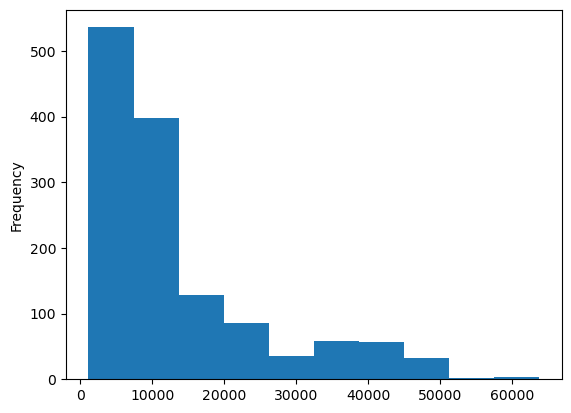

In [4]:
#showing the histogram of the outcome variable
insurance['charges'].plot.hist()
plt.show()

The charges column is highly skewed to the right. Extremely costly insurance charges are more common than extremely small ones. This makes it unlikely that the errors in the model will truly be centered at zero. It might be worth it to log-transform the outcome.

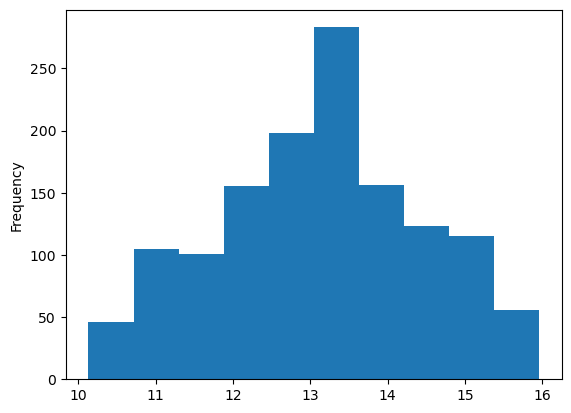

In [5]:
insurance['log_charges'] = np.log2(insurance['charges'])
insurance['log_charges'].plot.hist()
plt.show()

The log-transformed charges values are more centered, which is what we wanted. This makes it more likely that the errors will be unbiased.

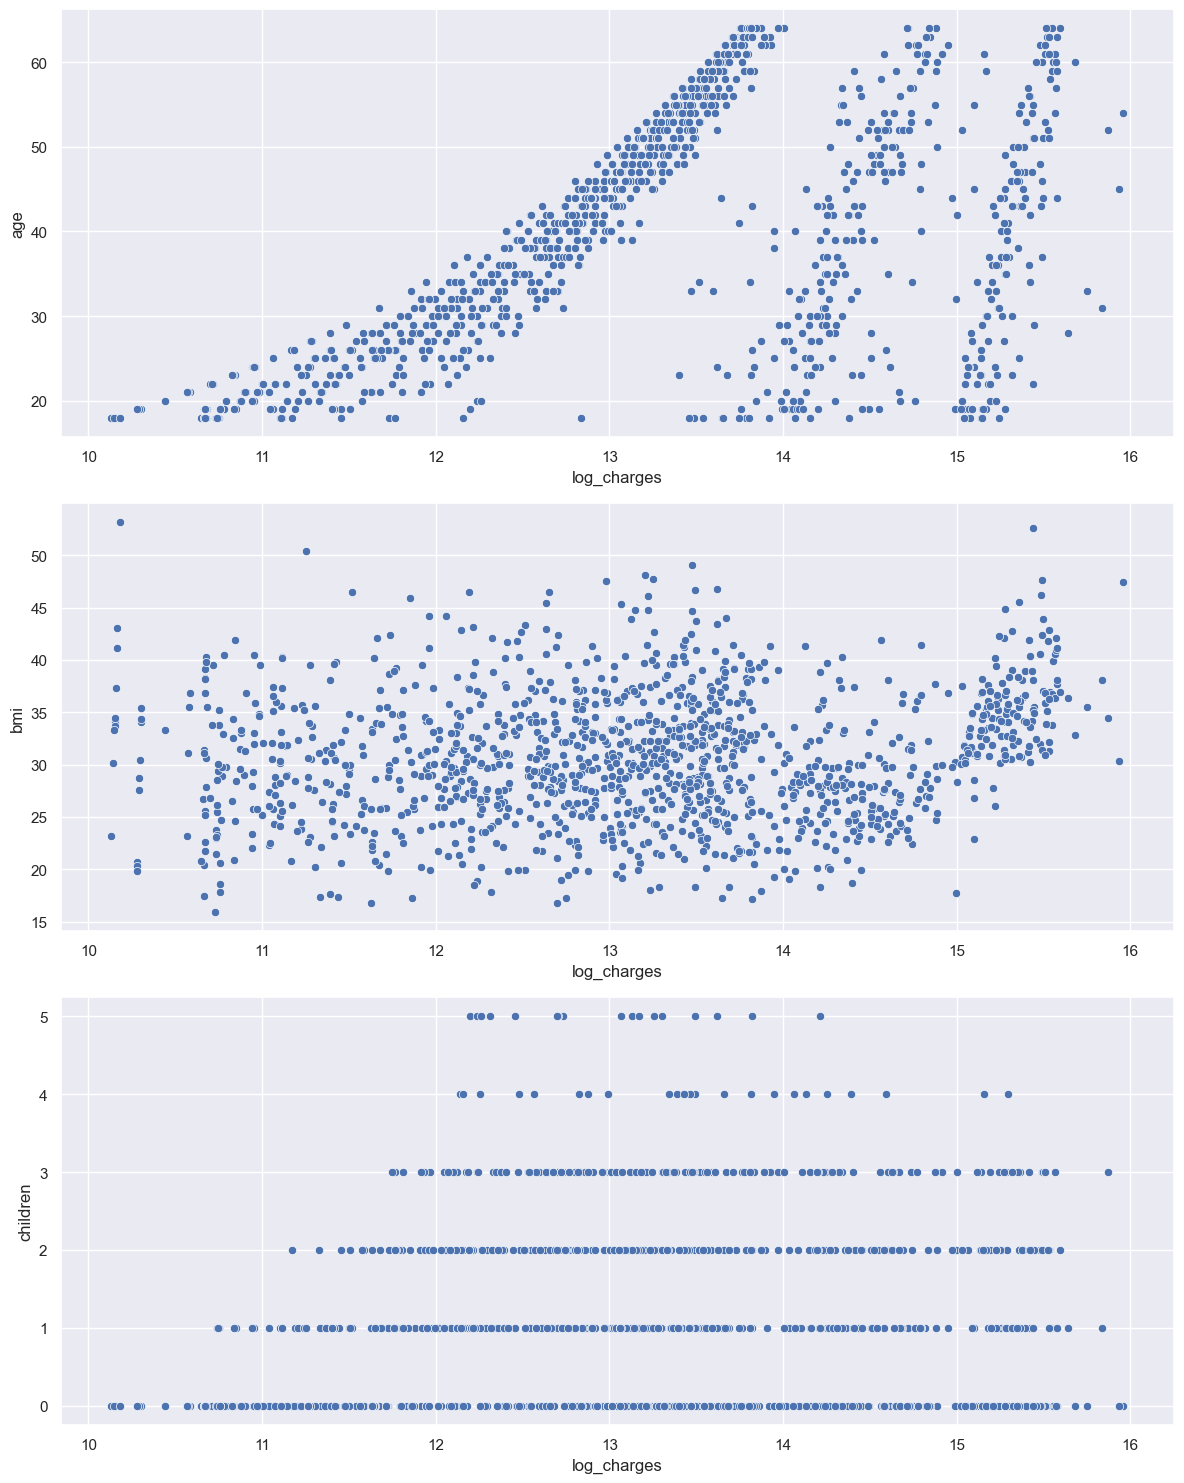

In [6]:
#visualizing the scatter plot of numerical columns with the outcome
numeric_columns = ['age','bmi','children']
sns.set_theme()
fig = plt.figure(figsize = (12,15))
for i, cl in enumerate(numeric_columns):
    if cl != 'log_charges' or cl != 'charges':
        ax = plt.subplot(3,1,i+1)
        sns.scatterplot(data = insurance, x = 'log_charges', y = cl, palette = 'tab10')
    
plt.tight_layout()
plt.show()

There are 3 categorical columns that should be investigated in terms of their relationship with the outcome:
* sex
* smoker
* region

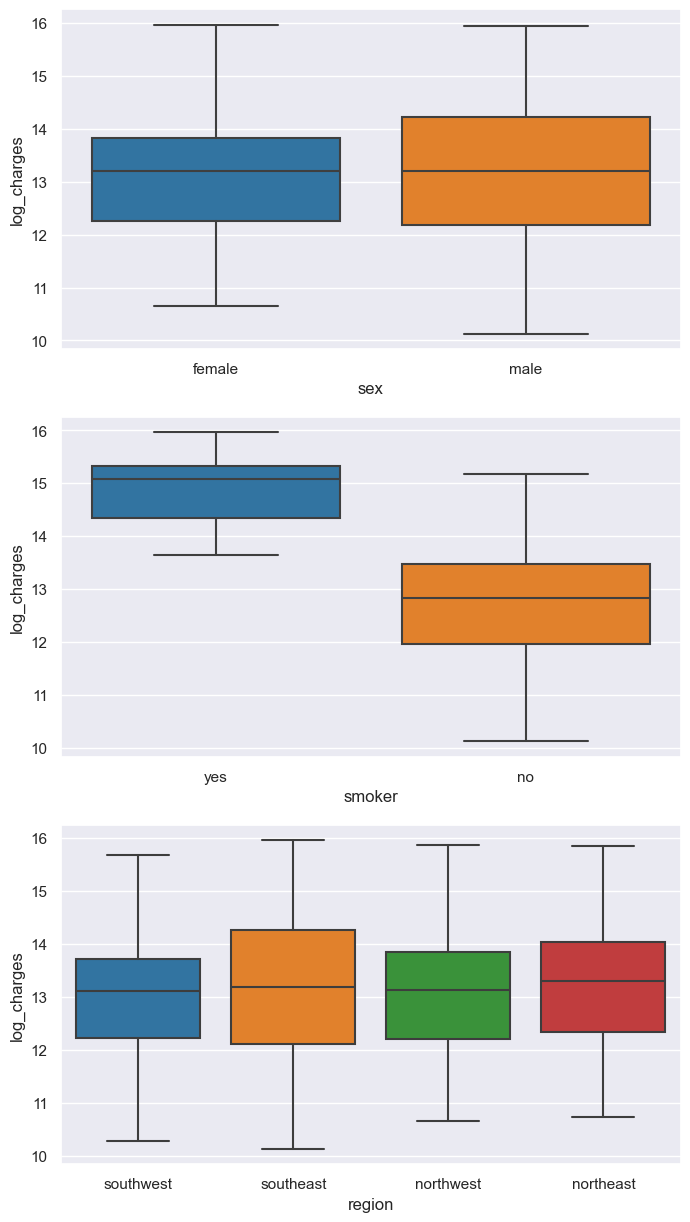

In [7]:
#creating a box plot for each categorical column 
categorical_columns = ['sex', 'smoker', 'region']
figure = plt.figure(figsize = (8,15))

for i, cl in enumerate(categorical_columns):
    ax = plt.subplot(3,1,i+1)
    sns.boxplot(data = insurance, x = cl, y = 'log_charges', ax = ax, palette = 'tab10')



The second chart, 'smoker' shows a high correlation with the outcome. Also, men tend to have a wider range of charges compared to women.

**Selecting features:**

Since age, bmi and smoker showed higher correlations with the outome(charges), I select them as the final predictors for my model.

## Building the model

In [15]:
#creating train and test sets, by 20% of data
insurance['is_smoker'] = (insurance['smoker'] == 'yes')
X = insurance[['age','bmi', 'is_smoker']]
y = insurance['log_charges']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 105)

In [16]:
#using the lineare regression model to fit our data

model = LinearRegression()
model.fit(X_train, y_train)

#using the model to predict y_train
y_pred_train = model.predict(X_train)

In [21]:
#finding out the performance of model using R2, MSE, and RMSE, and training sets
from math import e

r2_train = r2_score(y_pred_train, y_train)
mse_train = mean_squared_error(y_pred_train, y_train)
rmse_train = e**mse_train
print(f'R2 Score {r2_train:.2f} \nMSE train {mse_train:.2f} \nRMSE train {rmse_train:.2f}')

R2 Score 0.64 
MSE train 0.46 
RMSE train 1.59


The training MSE for the model is 0.46 and is 1.59 on the original scale. The R2 indicates that the model can explain 64% of the variation in the log-insurance charges. These preliminary results are promising, but we must remember that these are optimistic values.

## Residual Diagnostics

Now, we plot the residuals of the training set against true y values to examine their trend

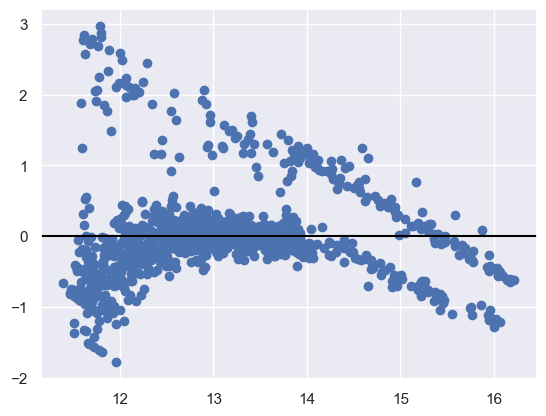

In [28]:
res_train = y_train - y_pred_train
plt.scatter(x = y_pred_train, y = res_train)
plt.axhline(0, color = 'black')
plt.show()

We expected that after transforming the outcome to a log scale, we would might have solved the problem of residuals, and the plot of residuals vs. predicted values should be centered around the zero line, while we see a downward trend in higher predicted y values. 

## Interpreting The Model

In [35]:
#checking the intercepts and coefficients

coef = model.coef_
coef_real = np.exp(coef)

print(coef, '\n',coef_real)

[0.04982862 0.01533572 2.20777257] 
 [1.05109094 1.01545391 9.0954344 ]


In [37]:
intercept = model.intercept_
print(intercept)

10.251297335257266


some points:
- a year increase in the age of patients, increases their corresponding charges around 5% on average, while controlling the effect of other variables. 

- an increase of one value in the bmi of patients, increases their charges around 1.5%.

- if a patinet is smoker,holding age and bmi constant. he/she might increase the charges around 910%. 

## Final Model Evaluation

In [38]:
#using test sets to find the metrics of the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.exp(mse)

print(f'R2 Score {r2:.2f} \nMSE train {mse:.2f} \nRMSE train {rmse:.2f}')

R2 Score 0.79 
MSE train 0.40 
RMSE train 1.49


We can't judge a model's performance using training sets. here, we used real test sets to evaluate the performance of our model.

The  MSE for the model is 0.40 and is 1.49 on the original scale. The R2 indicates that the model can explain 79% of the variation in the log-insurance charges. These results are better thant the training results, so we can conclude that the model is not overfit. 

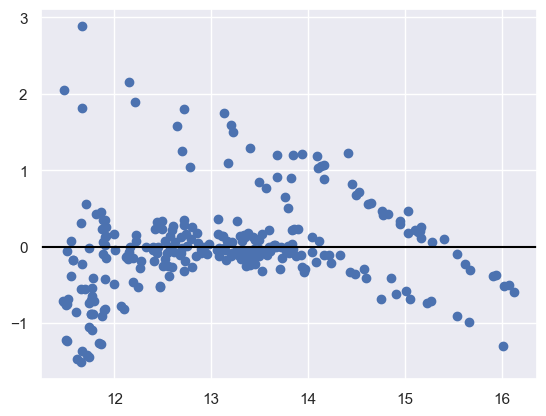

In [39]:
#evaluating residuals
res = y_test - y_pred
plt.scatter(y_pred, res)
plt.axhline(0, color = 'black')
plt.show()

## Conclusions:
As we can see, the residuals suggest that the model is predicting much lower costs for subjects who were actually charged much higher(since they go below the zero line). Therefore the model struggles with these higher costs. As a whole, the model predictions are  conservative.

**Possible imporvements:** We might improve the model by including more complex terms in the regression, such as interactions or quadratic terms.